# Lab 04: Extracting topics from research articles

# Part I: Data preprocessing

### Load dataset

- Source: https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles/version/1
- Download: https://georgetown.box.com/s/1qkrvdewe8ez35f2asblxysh136dvh6b

In [1]:
import pandas as pd

train_data = pd.read_csv('train.csv').sample(frac=1)
test_data = pd.read_csv('test.csv').sample(frac=1)

In [2]:
train_data.head(2)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
17625,17626,Crosscorrelation of Rudin-Shapiro-Like Polynom...,We consider the class of Rudin-Shapiro-like ...,1,0,1,0,0,0
3877,3878,Poisson multi-Bernoulli mixture filter: direct...,We provide a derivation of the Poisson multi...,1,0,0,1,0,0


In [3]:
for topic in train_data.columns[3:]:
    print(f"{topic}: {sum(train_data[topic]) / len(train_data):.3f}")

Computer Science: 0.410
Physics: 0.287
Mathematics: 0.268
Statistics: 0.248
Quantitative Biology: 0.028
Quantitative Finance: 0.012


### Reuse Spacy pipeline from Lab-02 for text normalization & preprocessing

In [18]:
import re
import spacy
from spacy.language import Language

M = 2500

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

train_sentences = []
for i, d in enumerate(train_data['ABSTRACT'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    train_sentences.append(d)


@Language.component("lab04Preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("lab04Preprocessor")

<function __main__.ng20_preprocess(doc)>

### Pass data through our Spacy pipeline

In [5]:
docs = []
for sent in train_sentences[:M]:
    docs.append(pipeline(sent))

### Compute number of unique words (vocabulary size)

In [6]:
vocab_size = len(set(" ".join(docs).split(" ")))
vocab_size

17106

# Part 2: Build Features

### Build the term-document matrix (i.e., BOW features)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_featurizer = CountVectorizer(max_features=vocab_size, max_df=0.95, min_df=0.005, stop_words='english')
tfidf_featurizer = TfidfVectorizer(max_features=vocab_size, max_df=0.95, stop_words='english')
X_bow = bow_featurizer.fit_transform(docs)
X_tfidf = tfidf_featurizer.fit_transform(docs)
type(X_bow), X_bow.shape

(scipy.sparse.csr.csr_matrix, (2500, 2025))

### Create a index-to-word map

In [8]:
idx2word = {idx: word for word, idx in bow_featurizer.vocabulary_.items()}

### Number of topics hyperparameter

In [9]:
# Configurable
K = 10

### Plotting subroutine to visualize words

In [10]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def plot_top_words(model, feature_names, n_top_words, title):
    plt.clf()
    cols = 5
    rows = K // 5 + K % 5
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### (10 pts) Task I: Build a LSA model

In this task we are going to build a LSA topic model from scratch. From lecture-04, we learned about LSA from the perspective of document retrieval. For document retrieval, you'll recall that we computed a truncated SVD by choosing some number of dimension $K << N$. This gave us the left singular column vectors, $\mathbf{V} \in \mathbb{R}^{N \times K}$, and the diagonal singular value matrix, $\boldsymbol{\Sigma} \in \mathbb{R}^{K \times K}$ that we needed in order to project our queries, $\mathbf{q} \in \mathbb{R}^{N}$, and documents, $\mathbf{d} \in \mathbb{R}^{N}$, into $\mathbb{R}^{K}$ space. Recall that the operation to do that was:

$$\hat{\mathbf{q}} = \mathbf{q}\mathbf{V}\mathbf{\Sigma}^{-1} $$

In this task, we're going to evaluate the singular values, $\sigma_{i,j}$ in $\mathbf{\Sigma}$, and their corresponding basis vectors, $\mathbf{u}^{(j)}$, in $\mathbf{U}$, to extract the principal themes in the data. Execute the following subtasks.

1. For each column vector, print out the top 10 most relevant words.
2. Visualize the top 10 words using the `plot_topics()` function provided above.
3. What affect does the hyperparameter $K$ have on the result?
4. Is there a principled way to determine an appropriate value for $K$?

In [11]:
from sklearn.decomposition import TruncatedSVD

In [25]:
## fit the model 
svd = TruncatedSVD(n_components=10, n_iter=100, random_state = 777)
svd.fit(X_bow)

TruncatedSVD(n_components=10, n_iter=100, random_state=777)

In [41]:
## print out the top 10 most relevant words
top_10_words = pd.DataFrame()  
feature_names = idx2word

for topic_idx, topic in enumerate(svd.components_):
    top_features_ind = topic.argsort()[::-1][:10] ## top_words = 10
    top_features = [feature_names[i] for i in top_features_ind]
    name = f"topic {topic_idx}"
    top_10_words[name] = top_features
    
top_10_words

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,number,number,model,network,network,problem,graph,method,time,graph
1,model,mass,datum,neural,field,graph,datum,graph,base,spin
2,result,_number,parameter,deep,study,model,structure,model,algorithm,state
3,method,galaxy,galaxy,learning,energy,algorithm,time,propose,approach,_number
4,datum,stellar,mass,task,time,network,vertex,equation,dynamic,magnetic
5,time,star,simulation,train,state,vertex,embed,edge,series,algorithm
6,base,m_,predict,image,phase,mathbb,edge,embed,control,image
7,high,rm,distribution,performance,spin,prove,data,state,flow,problem
8,network,left,phase,learn,magnetic,solution,analysis,class,energy,field
9,problem,sim,star,number,order,class,random,image,design,learn


<Figure size 432x288 with 0 Axes>

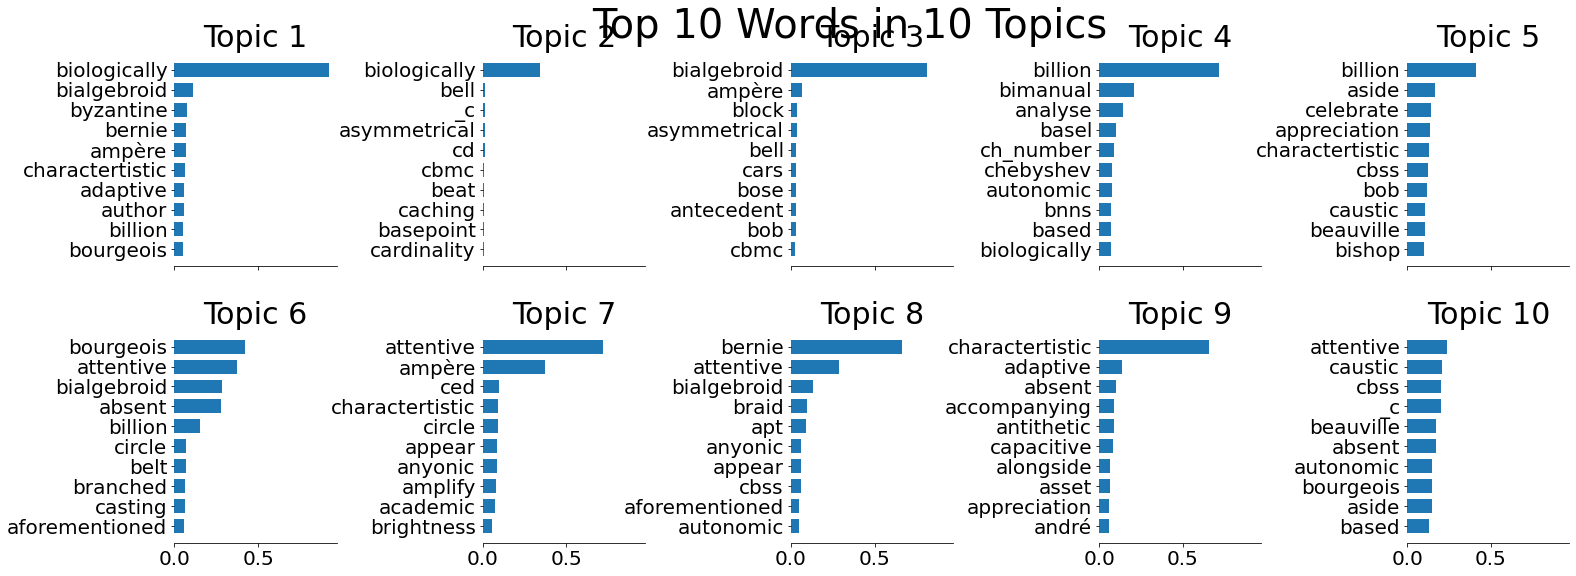

In [46]:
## visualize the top 10 words
features=tfidf_featurizer.get_feature_names()
plot_top_words(svd,features,10,"Top 10 Words in 10 Topics")

3. What affect does the hyperparameter 𝐾 have on the result?

The hyperparameter K is the number of topics set and also the number of dimensions to which the Document-Term Matrix is compressed by singular value decomposition(SVD). A higher K parameter setting means more topics are divided and may lead to correlations between topics; a smaller K parameter setting means fewer topics are divided, which results in more differences between topics, and fewer related topics.

4. Is there a principled way to determine an appropriate value for 𝐾 ?

We can use topic coherence to evaluate the model. Topic Coherence measure is a good way to compare difference topic models based on their human-interpretability. The u_mass and c_v topic coherences capture the optimal number of topics by giving the interpretability of these topics a number called coherence score. Besides, we can also use Topic Visualization to assess topic models. 

### (5 pts) Task 2: Perform topic extraction using the NMF and LDA models from sklearn

In this task we perform topic extraction using the Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) models provided by sklearn. 

1. Fit the NMF and LDA models in the provided cells below.
2. Visualize the results using the `plot_topics` function.
3. How do the results compare to your home-spun LSA topic model?
4. What are the differences between these model that might give rise to these results?

<Figure size 432x288 with 0 Axes>

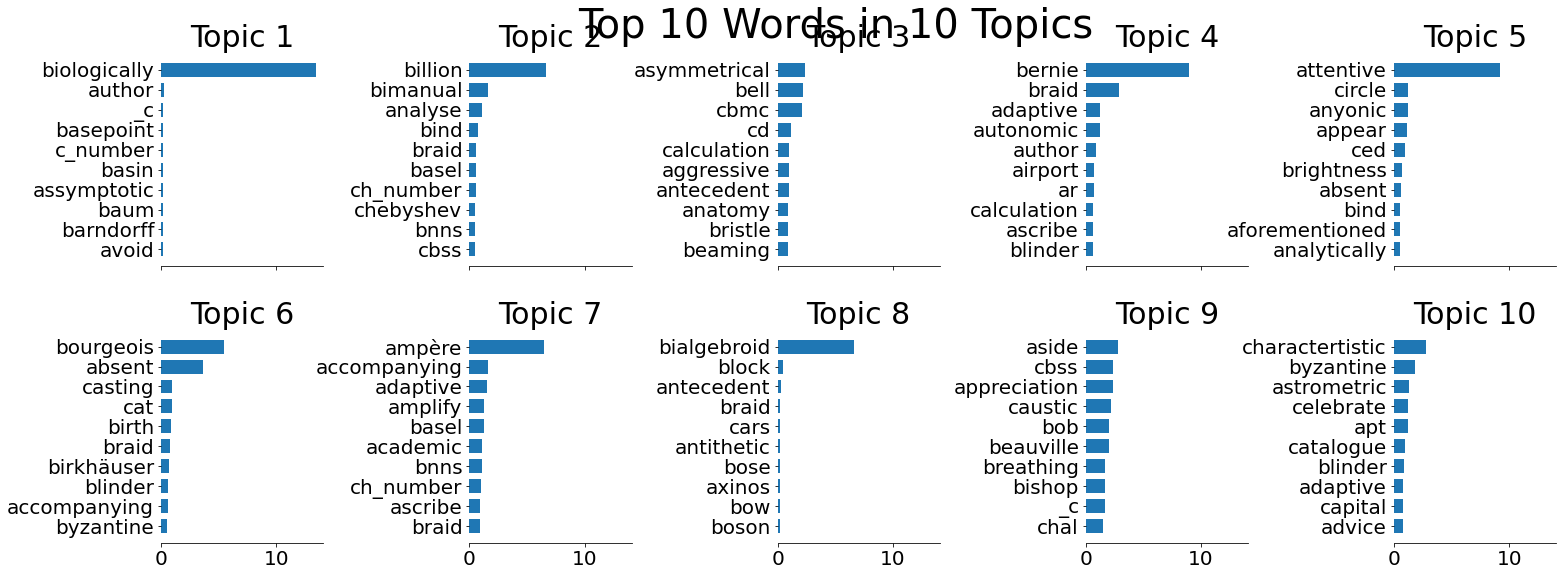

In [47]:
from sklearn.decomposition import NMF

## fit the model 
nmf=NMF(n_components=10, init='random', random_state=777)
nmf.fit(X_bow)

## visualize the results 
plot_top_words(nmf,features,10,"Top 10 Words in 10 Topics")

<Figure size 432x288 with 0 Axes>

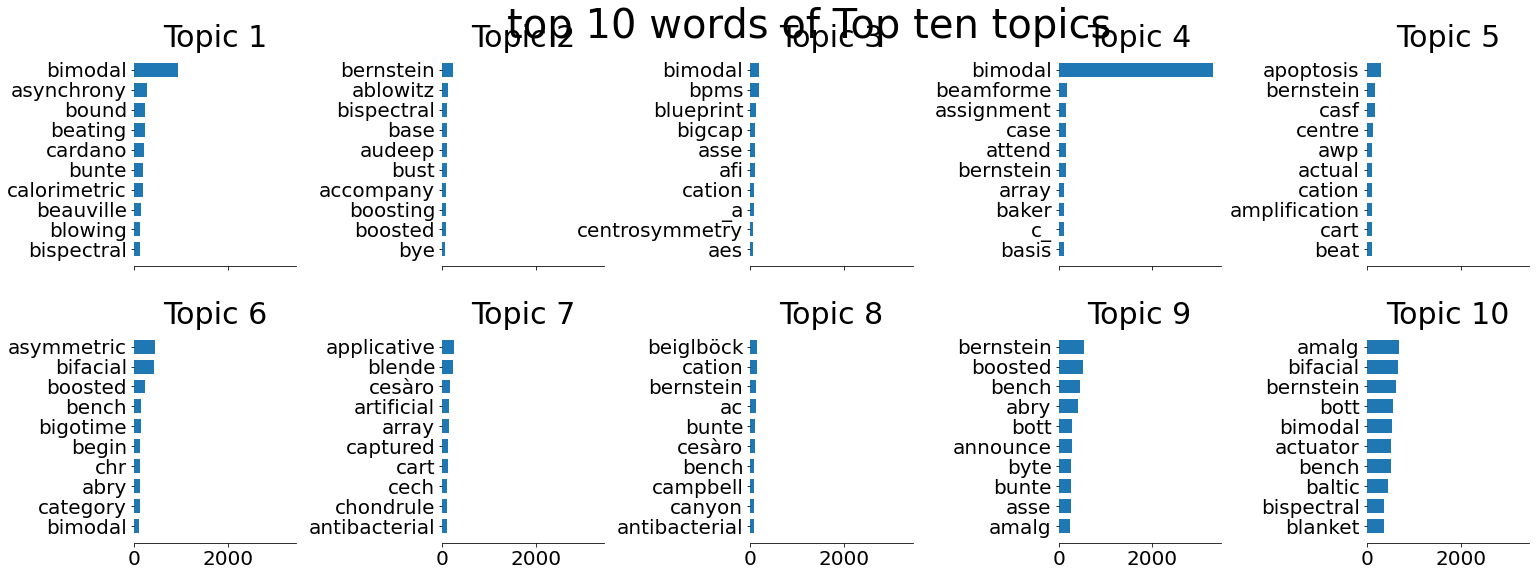

In [32]:
from sklearn.decomposition import LatentDirichletAllocation

## fit the model 
lda=LatentDirichletAllocation(n_components=10, random_state=777)
lda.fit(X_bow)

## visualize the results 
plot_top_words(lda, features, 10, 'Top 10 Words in 10 Topics')

3. How do the results compare to your home-spun LSA topic model?

The results of LDA and NMF are better than the home-spun LSA topic model because they do not have overfitting issues.  

4. What are the differences between these model that might give rise to these results?

Since LSA is a linear algebra method, it lacks a statistical basis, and the results are difficult to interpret intuitively. While LDA and NMF are probabilistic models. LDA uses Dirichlet prior, and because of the priors, LDA is less prone to over-fitting issues. 

### (5 pts) Task 3: Map the test data onto the topic spaces learned from the LSA, NMF, and LDA models

The purpose of this task is to assign topics to the test data

In [33]:
## text normalization & preprocessing
test_sentences = []
for i, d in enumerate(test_data['ABSTRACT'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    test_sentences.append(d)

test_docs = []
for sent in test_sentences[:M]:
    test_docs.append(pipeline(sent))

In [38]:
## Build the term-document matrix (i.e., BOW features)
X_test_bow = bow_featurizer.transform(test_docs)
X_test_tfidf = tfidf_featurizer.fit_transform(test_docs)

## LSA model
lsa_mt = svd.transform(X_test_bow)
lsa_mt

array([[ 2.15284269, -2.34176515,  1.42842879, ..., -0.6505424 ,
         0.95165048,  1.20993463],
       [ 2.90417176, -1.60776225,  1.60799378, ...,  0.94444044,
        -0.55360799,  1.75065344],
       [ 2.51313642, -0.52323854, -0.36953721, ..., -0.07786985,
        -0.58259775,  0.18626995],
       ...,
       [ 1.05024468, -3.00003866, -1.86957086, ..., -1.9527227 ,
         0.58072465,  0.96162779],
       [ 0.38096418, -0.90883935, -0.38801878, ..., -0.25246677,
        -1.04129275, -0.44182346],
       [ 0.82007023, -2.34291581, -1.21960291, ...,  1.08088191,
        -0.48657385,  0.49445606]])

In [37]:
## NMF model
nmf_mt = nmf.transform(X_test_bow)
nmf_mt

array([[0.07523986, 0.        , 0.03107441, ..., 0.30118811, 0.31816576,
        0.04632596],
       [0.14793759, 0.00074976, 0.        , ..., 0.31724216, 0.41990974,
        0.02910718],
       [0.1479227 , 0.        , 0.01506169, ..., 0.        , 0.17614377,
        0.21230441],
       ...,
       [0.        , 0.06414927, 0.00324569, ..., 0.01297221, 0.00821489,
        0.05258334],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0041624 ,
        0.19734779],
       [0.        , 0.25151012, 0.        , ..., 0.00299392, 0.07553091,
        0.        ]])

In [36]:
## LDA model
lda_mt = lda.transform(X_test_bow)
lda_mt

array([[0.00112381, 0.00112383, 0.00112395, ..., 0.27568909, 0.0011238 ,
        0.23403743],
       [0.12225358, 0.00133355, 0.00133358, ..., 0.00133355, 0.00133366,
        0.00133361],
       [0.33702697, 0.00188719, 0.00188758, ..., 0.12258114, 0.00188751,
        0.00188715],
       ...,
       [0.0011367 , 0.32231186, 0.00113656, ..., 0.00113657, 0.11849655,
        0.55123542],
       [0.29404031, 0.00370425, 0.00370505, ..., 0.0037049 , 0.27687191,
        0.00370491],
       [0.00204102, 0.00204121, 0.00204126, ..., 0.00204145, 0.36646781,
        0.25802173]])